In [2]:
import pandas as pd
from pathlib import Path

# 0. Path setting
DATA_DIR = Path("./drive/MyDrive/2025_DL_MIMIC_4/physionet.org/files/mimiciv/3.1/hosp/")


# 1. admissions: Calculate LOS & keep only admissions > 24 hours
admissions = pd.read_csv(
    DATA_DIR / "admissions.csv.gz",
    usecols=[
        "subject_id",
        "hadm_id",
        "admittime",
        "dischtime",
        "race",
    ],
    parse_dates=["admittime", "dischtime"],
)

# Calculate LOS (in hours)
admissions["los_hours"] = (admissions["dischtime"] - admissions["admittime"]) / pd.Timedelta(
    hours=1
)

# Exclude admissions with LOS <= 24 hours
admissions = admissions[admissions["los_hours"] > 24].copy()

cohort_hadm_ids = admissions["hadm_id"].unique()
print(f"Number of admissions with LOS > 24h: {len(cohort_hadm_ids)}")


# 2. patients: Join gender, age (based on subject_id)
patients = pd.read_csv(
    DATA_DIR / "patients.csv.gz",
    usecols=["subject_id", "gender", "anchor_age"],
)

# Join admissions + patients
df = admissions.merge(patients, on="subject_id", how="left")


# 3. services: Select last curr_service within 24 hours of admission per hadm_id
services = pd.read_csv(
    DATA_DIR / "services.csv.gz",
    usecols=["subject_id", "hadm_id", "transfertime", "curr_service"],
    parse_dates=["transfertime"],
)

# Only cohort (LOS > 24h) hadm
services = services[services["hadm_id"].isin(cohort_hadm_ids)].copy()
print(f"Number of services in cohort: {len(services)}")

# Join with admittime from admissions
services = services.merge(
    admissions[["hadm_id", "admittime"]],
    on="hadm_id",
    how="left"
)

# Calculate elapsed time since admission based on transfertime
services["time_since_admit_hours"] = (
    services["transfertime"] - services["admittime"]
) / pd.Timedelta(hours=1)

# Filter events only between 0-24 hours after admission
services_24h = services[
    (services["time_since_admit_hours"] >= 0) &
    (services["time_since_admit_hours"] <= 24)
].copy()

# Sort by transfertime
services_24h = services_24h.sort_values(["hadm_id", "transfertime"])

# Select the last curr_service within 24 hours
last_service_24h = (
    services_24h.groupby("hadm_id", as_index=False)["curr_service"].last()
)

# Join to df
df = df.merge(last_service_24h, on="hadm_id", how="left")


# 4. hcpcsevents: List of hcpcs_cd for admission day + next day
hcpcs = pd.read_csv(
    DATA_DIR / "hcpcsevents.csv.gz",
    usecols=["subject_id", "hadm_id", "chartdate", "hcpcs_cd"],
    parse_dates=["chartdate"],
)

# Only cohort
hcpcs = hcpcs[hcpcs["hadm_id"].isin(cohort_hadm_ids)].copy()

# Join with admissions(admittime) to calculate 'admission date'
hcpcs = hcpcs.merge(
    admissions[["hadm_id", "admittime"]],
    on="hadm_id",
    how="left",
)

# Calculate admission date (floor to day) and the next day
hcpcs["admit_date"] = hcpcs["admittime"].dt.floor("D")
hcpcs["next_date"] = hcpcs["admit_date"] + pd.Timedelta(days=1)

# Use only rows where chartdate is on the admission day or the next day
hcpcs_24h = hcpcs[
    (hcpcs["chartdate"] >= hcpcs["admit_date"])
    & (hcpcs["chartdate"] <= hcpcs["next_date"])
].copy()

# Aggregate hcpcs_cd list per hadm_id
hcpcs_list = (
    hcpcs_24h.groupby("hadm_id")["hcpcs_cd"]
    .apply(list)
    .reset_index()
    .rename(columns={"hcpcs_cd": "hcpcs_cd_list"})
)
print(f"Number of hcpcs_list in cohort: {len(hcpcs_list)}")

df = df.merge(hcpcs_list, on="hadm_id", how="left")


# 5. diagnoses_icd: List of icd_code per hadm_id
diagnoses = pd.read_csv(
    DATA_DIR / "diagnoses_icd.csv.gz",
    usecols=["subject_id", "hadm_id", "icd_code", "icd_version"],
)

diagnoses = diagnoses[diagnoses["hadm_id"].isin(cohort_hadm_ids)].copy()

diag_list = (
    diagnoses.groupby("hadm_id")["icd_code"]
    .apply(list)
    .reset_index()
    .rename(columns={"icd_code": "diagnoses_icd_code_list"})
)
print(f"Number of diag_list in cohort: {len(diag_list)}")

df = df.merge(diag_list, on="hadm_id", how="left")


# 6. procedures_icd: Procedures on admission day / next day
procedures = pd.read_csv(
    DATA_DIR / "procedures_icd.csv.gz",
    usecols=["subject_id", "hadm_id", "chartdate", "icd_code", "icd_version"],
    parse_dates=["chartdate"],
)

# Only cohort hadm
procedures = procedures[procedures["hadm_id"].isin(cohort_hadm_ids)].copy()

# Get admittime from admissions to calculate admission date
procedures = procedures.merge(
    admissions[["hadm_id", "admittime"]],
    on="hadm_id",
    how="left",
)

procedures["admit_date"] = procedures["admittime"].dt.floor("D")
procedures["next_date"] = procedures["admit_date"] + pd.Timedelta(days=1)

# Keep only rows where chartdate is on the admission day or the next day
procedures_24h = procedures[
    (procedures["chartdate"] >= procedures["admit_date"]) &
    (procedures["chartdate"] <= procedures["next_date"])
].copy()

# Convert icd_code to string unconditionally
procedures_24h["icd_code"] = procedures_24h["icd_code"].astype(str)

# Aggregate icd_code list per hadm_id (icd_version is not saved)
proc_list = (
    procedures_24h.groupby("hadm_id")["icd_code"]
    .apply(list)
    .reset_index()
    .rename(columns={"icd_code": "procedures_icd_code_list"})
)

print(f"Number of proc_list in cohort: {len(proc_list)}")

df = df.merge(proc_list, on="hadm_id", how="left")


# 7. drgcodes: Use only APR, join by hadm_id
drg = pd.read_csv(
    DATA_DIR / "drgcodes.csv.gz",
    usecols=
        [
        "subject_id",
        "hadm_id",
        "drg_type",
        "drg_code",
        "drg_severity",
        "drg_mortality",
    ],
)

# Only cohort + drg_type = 'APR'
drg = drg[
    (drg["hadm_id"].isin(cohort_hadm_ids)) & (drg["drg_type"] == "APR")
].copy()

drg = drg.sort_values(["hadm_id"])
drg_unique = drg.drop_duplicates(subset=["hadm_id"], keep="first")
print(f"Number of drg_unique in cohort: {len(drg_unique)}")

df = df.merge(
    drg_unique[["hadm_id", "drg_code", "drg_severity", "drg_mortality"]],
    on="hadm_id",
    how="left",
)

# 8. emar: Medication list within 24 hours
emar = pd.read_csv(
    DATA_DIR / "emar.csv.gz",
    usecols=[
        "subject_id",
        "hadm_id",
        "emar_id",
        "medication",
        "charttime",
    ],
    parse_dates=["charttime"],
)

emar = emar[emar["hadm_id"].isin(cohort_hadm_ids)].copy()

emar = emar.merge(
    admissions[["hadm_id", "admittime"]],
    on="hadm_id",
    how="left",
)

emar["time_since_admit_hours"] = (
    emar["charttime"] - emar["admittime"]
) / pd.Timedelta(hours=1)

emar_24h = emar[
    (emar["time_since_admit_hours"] >= 0) & (emar["time_since_admit_hours"] <= 24)
].copy()

emar_list = (
    emar_24h.groupby("hadm_id")["medication"]
    .apply(list)
    .reset_index()
    .rename(columns={"medication": "medication_list"})
)
print(f"Number of emar_list in cohort: {len(emar_list)}")

df = df.merge(emar_list, on="hadm_id", how="left")


# 9. poe: order_type list within 24 hours
poe = pd.read_csv(
    DATA_DIR / "poe.csv.gz",
    usecols=[
        "subject_id",
        "hadm_id",
        "poe_id",
        "ordertime",
        "order_type",
    ],
    parse_dates=["ordertime"],
)

poe = poe[poe["hadm_id"].isin(cohort_hadm_ids)].copy()

poe = poe.merge(
    admissions[["hadm_id", "admittime"]],
    on="hadm_id",
    how="left",
)

poe["time_since_admit_hours"] = (
    poe["ordertime"] - poe["admittime"]
) / pd.Timedelta(hours=1)

poe_24h = poe[
    (poe["time_since_admit_hours"] >= 0) & (poe["time_since_admit_hours"] <= 24)
].copy()

poe_list = (
    poe_24h.groupby("hadm_id")["order_type"]
    .apply(list)
    .reset_index()
    .rename(columns={"order_type": "order_type_list"})
)
print(f"Number of poe_list in cohort: {len(poe_list)}")

df = df.merge(poe_list, on="hadm_id", how="left")

Number of admissions with LOS > 24h: 425090
Number of services in cohort: 470776
Number of hcpcs_list in cohort: 46150
Number of diag_list in cohort: 424803
Number of proc_list in cohort: 198553
Number of drg_unique in cohort: 346780
Number of emar_list in cohort: 232512
Number of poe_list in cohort: 421947


In [4]:
# 10. Verify results & Save
print(df.head(20))
print(df.columns)
print(len(df))
# Save
df.to_parquet("los_dataset_24h.parquet", index=False)

    subject_id   hadm_id           admittime           dischtime  \
0     10000032  22841357 2180-06-26 18:27:00 2180-06-27 18:49:00   
1     10000032  25742920 2180-08-05 23:44:00 2180-08-07 17:50:00   
2     10000032  29079034 2180-07-23 12:35:00 2180-07-25 17:55:00   
3     10000084  23052089 2160-11-21 01:56:00 2160-11-25 14:52:00   
4     10000117  27988844 2183-09-18 18:10:00 2183-09-21 16:30:00   
5     10000560  28979390 2189-10-15 10:30:00 2189-10-17 15:00:00   
6     10000690  23280645 2150-09-16 19:48:00 2150-09-24 13:50:00   
7     10000690  25860671 2150-11-02 18:02:00 2150-11-12 13:45:00   
8     10000690  26146595 2152-01-28 23:40:00 2152-01-30 15:56:00   
9     10000690  26504700 2150-07-03 02:46:00 2150-07-07 15:42:00   
10    10000719  24558333 2140-04-15 00:14:00 2140-04-18 12:29:00   
11    10000764  27897940 2132-10-14 23:31:00 2132-10-19 16:30:00   
12    10000826  20032235 2146-12-05 19:07:00 2146-12-12 16:30:00   
13    10000826  21086876 2146-12-18 17:39:00 214

In [5]:
# Check NaN counts
print("===== NaN counts per column (original df) ===%%")
print(df.isna().sum())
print("\nTotal number of rows:", len(df))

# 1) List columns: NaN → Fill with empty list
list_cols = [
    "hcpcs_cd_list",
    "procedures_icd_code_list",
    "medication_list",
    "order_type_list",
]

for col in list_cols:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])

# 2) Single categorical columns: NaN → Fill with 'UNKNOWN' etc.
if "curr_service" in df.columns:
    df["curr_service"] = df["curr_service"].fillna("UNKNOWN")

if "drg_code" in df.columns:
    df["drg_code"] = pd.to_numeric(df["drg_code"], errors="coerce")
    df["drg_code"] = df["drg_code"].fillna(-1).astype("int64")
if "drg_severity" in df.columns:
    df["drg_severity"] = df["drg_severity"].fillna(-1).astype("int64")
if "drg_mortality" in df.columns:
    df["drg_mortality"] = df["drg_mortality"].fillna(-1).astype("int64")

# 3) Remove NaN only from truly important columns (e.g., diagnosis information)
must_have_cols = ["diagnoses_icd_code_list"]

df_clean = df.dropna(subset=must_have_cols).copy()

print("\n===== NaN counts per column (after processing df_clean) ===%%")
print(df_clean.isna().sum())
print("\n===== Total number of rows (after processing) ===%%")
print(len(df_clean))

# Save
df_clean.to_parquet("los_dataset_24h.parquet", index=False)

===== 각 컬럼별 NaN 개수 (원본 df) =====
subject_id                       0
hadm_id                          0
admittime                        0
dischtime                        0
race                             0
los_hours                        0
gender                           0
anchor_age                       0
curr_service                 26786
hcpcs_cd_list               378940
diagnoses_icd_code_list        287
procedures_icd_code_list    226537
drg_code                     78310
drg_severity                 78310
drg_mortality                78310
medication_list             192578
order_type_list               3143
dtype: int64

총 row 수: 425090

===== 각 컬럼별 NaN 개수 (처리 후 df_clean) =====
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
race                        0
los_hours                   0
gender                      0
anchor_age                  0
curr_service                0
hcpcs_cd_list               0


==== Data Shape (row, col) ====
(424803, 17)

==== Column Types ====
subject_id                           int64
hadm_id                              int64
admittime                   datetime64[ns]
dischtime                   datetime64[ns]
race                                object
los_hours                          float64
gender                              object
anchor_age                           int64
curr_service                        object
hcpcs_cd_list                       object
diagnoses_icd_code_list             object
procedures_icd_code_list            object
drg_code                             int64
drg_severity                         int64
drg_mortality                        int64
medication_list                     object
order_type_list                     object
dtype: object

==== Basic Statistics (Key Numerical Columns) ====
           los_hours     anchor_age       drg_code   drg_severity  \
count  424803.000000  424803.000000  424803.000000  424803.000000

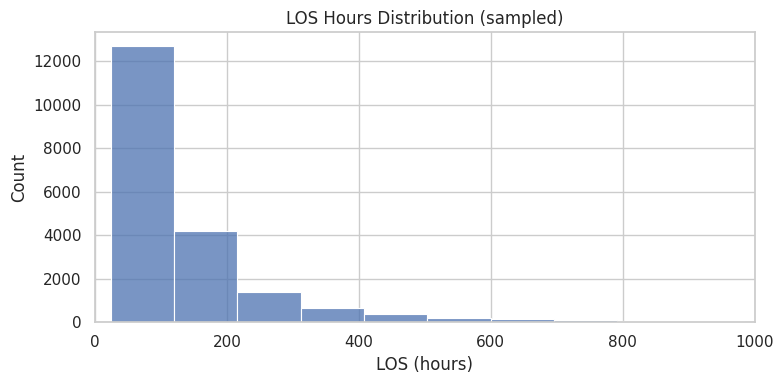

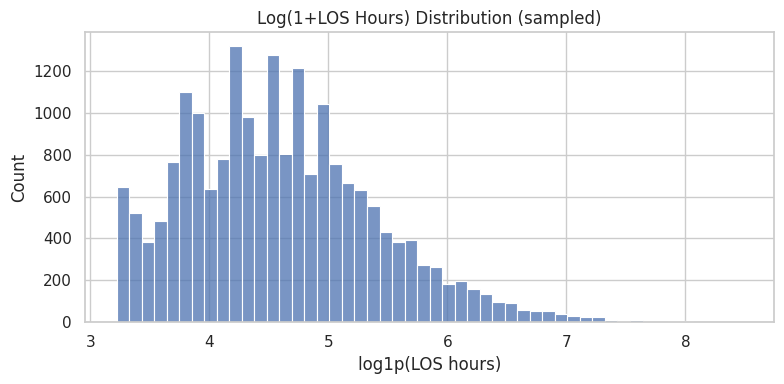

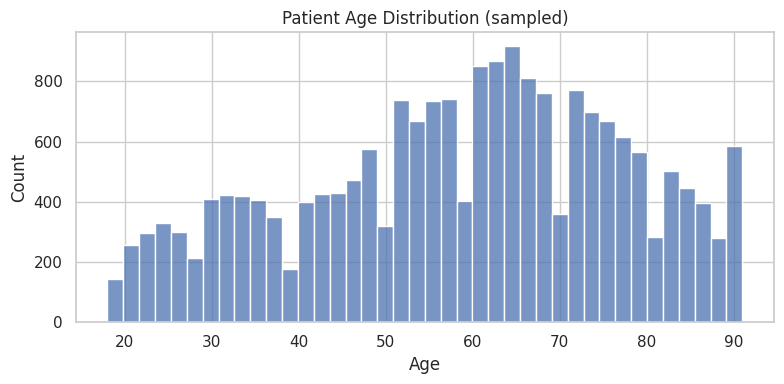

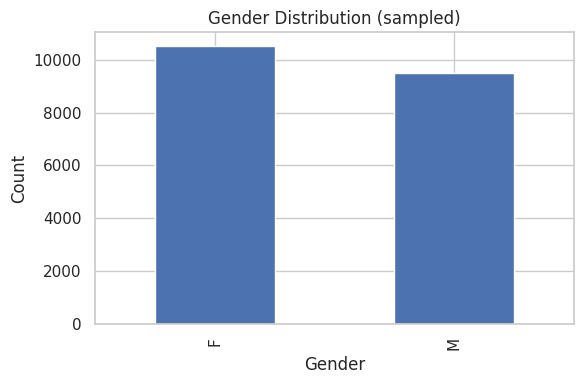

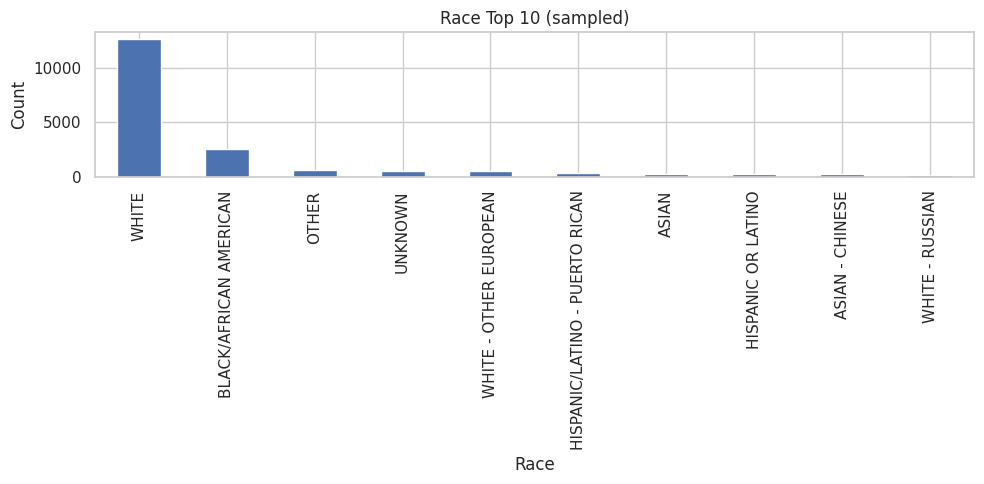

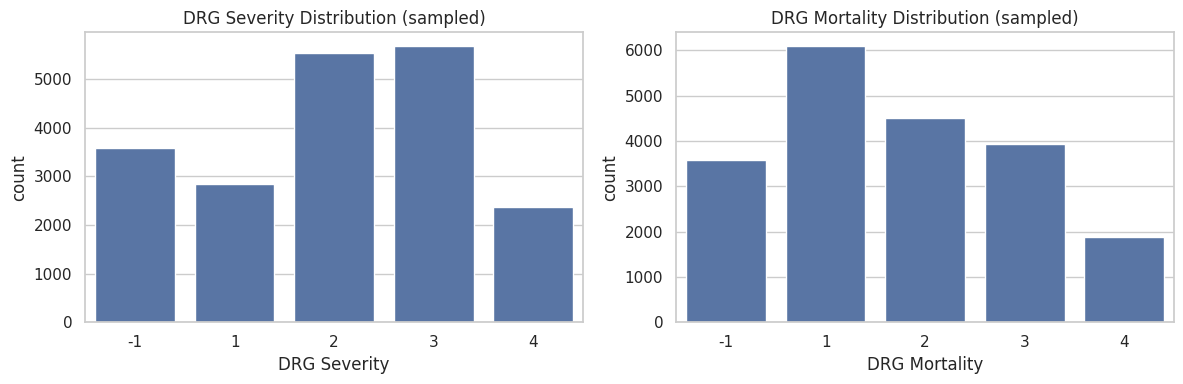

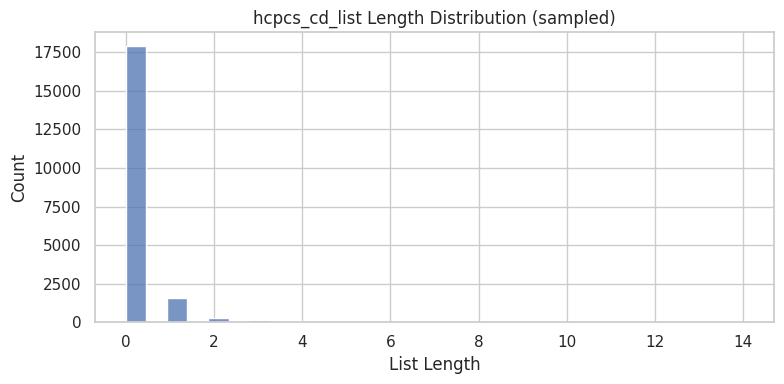

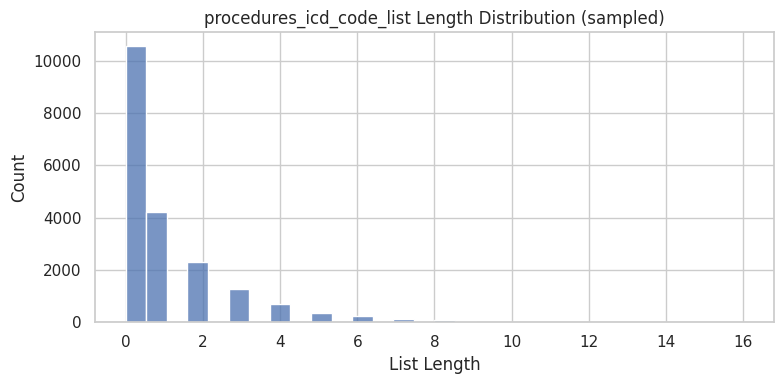

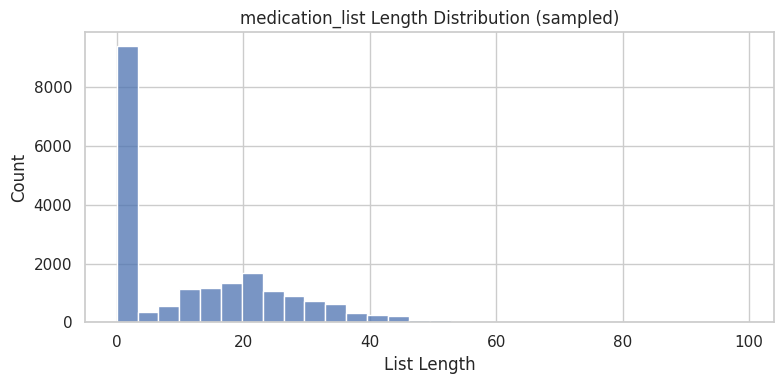

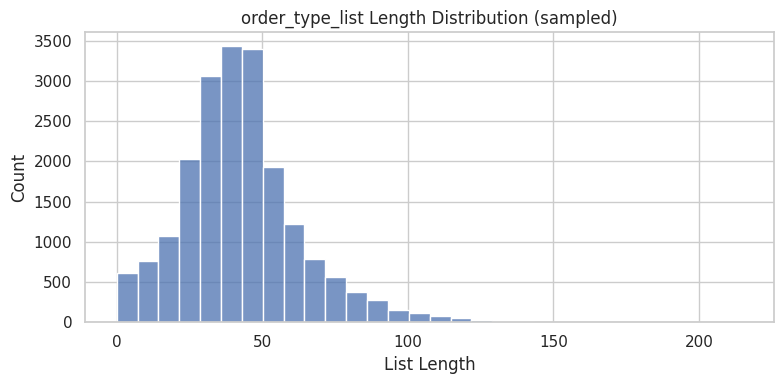


==== EDA Complete ====


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 0. Load Data
df_clean = pd.read_parquet("los_dataset_24h.parquet")

print("==== Data Shape (row, col) ====")
print(df_clean.shape)

print("\n==== Column Types ====")
print(df_clean.dtypes)


# 1. Basic Statistics
# Numerical: only key numerical columns, excluding datetime
num_cols = ["los_hours", "anchor_age", "drg_code", "drg_severity", "drg_mortality"]
print("\n==== Basic Statistics (Key Numerical Columns) ====")
print(df_clean[num_cols].describe())
print(f"  - Min LOS (hours): {df_clean['los_hours'].min():.3f}")
print(f"  - Max LOS (hours): {df_clean['los_hours'].max():.3f}")

# Categorical: only key categorical columns
cat_cols = ["gender", "race", "curr_service"]
print("\n==== Basic Statistics (Key Categorical Columns) ====")
print(df_clean[cat_cols].describe())


# 2. List Column Length Statistics
list_cols = [
    "hcpcs_cd_list",
    "procedures_icd_code_list",
    "medication_list",
    "order_type_list",
]

print("\n==== List Column Length Statistics ====")
for col in list_cols:
    lengths = df_clean[col].apply(len)
    df_clean[f"{col}_len"] = lengths  # Cache for later plotting
    print(f"[{col}]")
    print(f"  - Average length: {lengths.mean():.3f}")
    print(f"  - Median: {lengths.median():.3f}")
    print(f"  - Max length: {lengths.max()}")
    print()


# 3. Top-k values for key categorical features
print("\n==== Top 10 curr_service ====")
print(df_clean["curr_service"].value_counts().head(10))

print("\n==== Top 10 gender ====")
print(df_clean["gender"].value_counts().head(10))

print("\n==== Top 10 race ====")
print(df_clean["race"].value_counts().head(10))


# 4. Diagnosis Code Distribution
print("\n==== Top 10 diagnosis codes ====")
diag_counter = Counter()
for codes in df_clean["diagnoses_icd_code_list"]:
    diag_counter.update(codes)

for code, cnt in diag_counter.most_common(10):
    print(f"{code}: {cnt}")


# 5. Sampling for plots
SAMPLE_N = 20000
if len(df_clean) > SAMPLE_N:
    df_plot = df_clean.sample(SAMPLE_N, random_state=42)
else:
    df_plot = df_clean.copy()

print(f"\n==== Plots drawn with {len(df_plot)} samples ====")

sns.set(style="whitegrid")

# 5-1) LOS Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_plot["los_hours"], bins=50)
plt.title("LOS Hours Distribution (sampled)")
plt.xlabel("LOS (hours)")
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

# 5-2) LOS log-scale distribution
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df_plot["los_hours"]), bins=50)
plt.title("Log(1+LOS Hours) Distribution (sampled)")
plt.xlabel("log1p(LOS hours)")
plt.tight_layout()
plt.show()

# 5-3) Age Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_plot["anchor_age"], bins=40)
plt.title("Patient Age Distribution (sampled)")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

# 5-4) Gender Distribution
plt.figure(figsize=(6, 4))
df_plot["gender"].value_counts().plot(kind="bar")
plt.title("Gender Distribution (sampled)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5-5) Top 10 Race Distribution
plt.figure(figsize=(10, 5))
df_plot["race"].value_counts().head(10).plot(kind="bar")
plt.title("Race Top 10 (sampled)")
plt.xlabel("Race")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5-6) DRG severity / mortality Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=df_plot["drg_severity"], ax=axes[0])
axes[0].set_title("DRG Severity Distribution (sampled)")
axes[0].set_xlabel("DRG Severity")

sns.countplot(x=df_plot["drg_mortality"], ax=axes[1])
axes[1].set_title("DRG Mortality Distribution (sampled)")
axes[1].set_xlabel("DRG Mortality")

plt.tight_layout()
plt.show()

# 5-7) List Length Histogram
for col in list_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_plot[f"{col}_len"], bins=30)
    plt.title(f"{col} Length Distribution (sampled)")
    plt.xlabel("List Length")
    plt.tight_layout()
    plt.show()

print("\n==== EDA Complete ====")